In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import sys
print(os.listdir('../input'))

# Any results you write to the current directory are saved as output.

['resized-2015-2019-blindness-detection-images', 'resnet50', 'aptos2019-blindness-detection']


In [2]:
import torch
from tqdm import tqdm, tqdm_notebook
import random, torch, os, numpy as np
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
import scipy as sp

torch.backends.cudnn.deterministic = True

# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# SEED = 999
# seed_everything(SEED)

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from zipfile import ZipFile
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.vision import *
from fastai.callbacks import *
from sklearn.metrics import confusion_matrix, cohen_kappa_score

In [5]:
bs = 64

!ls

__notebook__.ipynb  __output__.json


In [6]:
# # copy pretrained weights for resnet50 to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/resnet50/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'
#resnet50-19c8e357
#resnet34-333f7ec4

In [7]:
print(os.listdir('../input/resized-2015-2019-blindness-detection-images/'))

['resized test 15', 'labels', 'resized train 15', 'resized test 19', 'resized train 19']


In [8]:
def get_df():
    base_image_dir = os.path.join('..', 'input/resized-2015-2019-blindness-detection-images/')
    train_dir = os.path.join(base_image_dir,'resized train 15/')
    df = pd.read_csv(os.path.join(base_image_dir, 'labels/trainLabels15.csv'))
    df['path'] = df['image'].map(lambda x: os.path.join(train_dir,'{}.jpg'.format(x)))
    df = df.drop(columns=['image'])
    df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
    test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
    return df, test_df

df, test_df = get_df()

   level                                               path
0      0  ../input/resized-2015-2019-blindness-detection...
1      0  ../input/resized-2015-2019-blindness-detection...
2      2  ../input/resized-2015-2019-blindness-detection...
3      1  ../input/resized-2015-2019-blindness-detection...
4      0  ../input/resized-2015-2019-blindness-detection...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f648101f198>]], dtype=object)

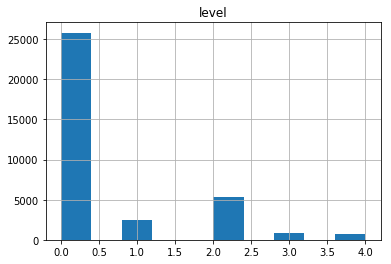

In [9]:
print(df.head())
df.hist()

In [10]:
# # create Stratified validation split (12.50%)
# #fastai does not include stratify option in train test data split, however according to the lecturer, 
# #imbalance classifiers will be handle by the deep learning quite well, not sure this is true in this case
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(n_splits=8, random_state=999)
# tr_ids, val_ids = next(cv.split(df_train.id_code, df_train.diagnosis))
# print(len(tr_ids), len(val_ids))
# _ = df_train.loc[val_ids].hist()

In [11]:
# print(val_ids)
# print(tr_ids)

In [12]:
# import zipfile
# with zipfile.ZipFile('./train_images.zip', 'r') as zip_ref:
#     zip_ref.extractall('./train_images')

In [13]:
# with zipfile.ZipFile('./test_images.zip', 'r') as zip_ref:
#     zip_ref.extractall('./test_images')

In [14]:
tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0.2, 0.8), 'col_pct': (0.2, 0.8), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])


In [15]:
#create data using fastai ImageDataBunch function, create from image list with lable.
#simple data augmentation with flip and rotate since this is an eyeball image, the image is normalized using default imagenet_stats, another possible 
#option would be use the aptos19_stats, which not sure how to derive from yet
# create image data bunch
# 
# create image data bunch
# data = ImageDataBunch.from_df('./', 
#                               df=df, 
#                               valid_pct=0.2,
#                               folder="../input/diabetic-retinopathy-resized/resized_train",
#                               suffix=".jpeg",
#                               ds_tfms=tfms,
#                               size=224,
#                               resize_method=ResizeMethod.SQUISH,
#                               bs=96, 
#                               num_workers=0,
#                              label_col='level', label_delim=',').normalize(imagenet_stats)

In [16]:
data = (ImageList.from_df(df=df,path='./', cols='path') 
        .split_by_rand_pct(0.2) 
        .label_from_df(cols='level',label_cls=FloatList) 
        .transform(tfms,size=224,padding_mode='zeros') 
        .databunch(bs=96,num_workers=4) 
        .normalize(imagenet_stats)  
       )

In [17]:
# data.show_batch(rows=3, figsize=(7,6))

In [18]:
def quad_kappa(y_pred, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')

In [19]:
learn = cnn_learner(data, models.resnet50, metrics=quad_kappa,
                    loss_func = MSELossFlat(),
                    callback_fns=[
                              partial(EarlyStoppingCallback, monitor='quad_kappa', min_delta=0.001, patience=1),
                              partial(ReduceLROnPlateauCallback),
                              partial(SaveModelCallback, every = 'improvement', monitor='quad_kappa', name='bestmodel')],
                    model_dir="/tmp/").to_fp16()

In [20]:
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.45E-04


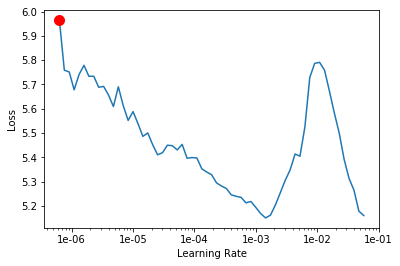

In [21]:
learn.recorder.plot(suggestion=True)

In [22]:
learn.fit_one_cycle(9,2.75e-2)

epoch,train_loss,valid_loss,quad_kappa,time
0,0.813622,0.693567,0.424810,19:47
1,0.759738,0.774646,0.512395,19:59
2,0.657182,0.656432,0.426822,20:05


Better model found at epoch 0 with quad_kappa value: 0.42480993270874023.
Epoch 1: reducing lr to 0.004673945016216092
Better model found at epoch 1 with quad_kappa value: 0.5123952627182007.
Epoch 3: early stopping
Epoch 3: reducing lr to 0.004941216291537512


In [23]:
learn.fit_one_cycle(6,1e-4)

epoch,train_loss,valid_loss,quad_kappa,time
0,0.601784,0.593639,0.522748,19:27
1,0.572618,0.567579,0.548752,16:44
2,0.572908,0.555557,0.563654,19:16
3,0.566635,0.549295,0.563029,16:54
4,0.543180,0.546391,0.575659,16:57
5,0.536770,0.545360,0.571529,16:59


Better model found at epoch 0 with quad_kappa value: 0.5227484703063965.
Better model found at epoch 1 with quad_kappa value: 0.548751711845398.
Better model found at epoch 2 with quad_kappa value: 0.5636541843414307.
Better model found at epoch 4 with quad_kappa value: 0.5756589770317078.


In [24]:
base_image_dir2 = os.path.join('..', 'input/aptos2019-blindness-detection/')
train_dir2 = os.path.join(base_image_dir2,'train_images/')
df2 = pd.read_csv(os.path.join(base_image_dir2, 'train.csv'))
df2['path'] = df2['id_code'].map(lambda x: os.path.join(train_dir2,'{}.png'.format(x)))
df2 = df2.drop(columns=['id_code'])
df2 = df2.sample(frac=1).reset_index(drop=True) #shuffle dataframe

In [25]:
data2 = (ImageList.from_df(df=df2,path='./',cols='path') 
        .split_by_rand_pct(0.2) 
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=278,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=96,num_workers=8) 
        .normalize(imagenet_stats)  
       )
learn.data = data2
learn.to_fp16()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.98E-03


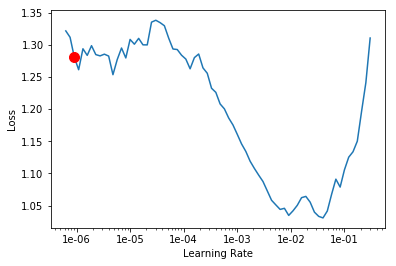

In [26]:
learn.recorder.plot(suggestion=True)

In [27]:
# !cp '../input/newcrop/bestmodel3.pth' '/tmp/'
# !ls /tmp

In [28]:
# learn.save('stage-1');
# learn.unfreeze()
# learn.lr_find(start_lr = 1e-10)

In [29]:
# learn.recorder.plot(suggestion=True)

In [30]:
learn.fit_one_cycle(10, 1e-2)
learn.fit_one_cycle(10,1e-4)
learn.freeze_to(-3)
learn.fit_one_cycle(10,slice(1e-6,1e-4))
learn.unfreeze()
learn.fit_one_cycle(3,slice(1e-8,1e-6))

epoch,train_loss,valid_loss,quad_kappa,time
0,0.672731,0.391323,0.830727,08:47
1,0.495684,0.318017,0.884132,08:08
2,0.442389,0.536110,0.803839,08:01
3,0.390658,0.281834,0.896960,08:03
4,0.359349,0.338671,0.864224,08:03


Better model found at epoch 0 with quad_kappa value: 0.8307265043258667.
Better model found at epoch 1 with quad_kappa value: 0.8841318488121033.
Epoch 2: reducing lr to 0.002
Better model found at epoch 3 with quad_kappa value: 0.8969599604606628.
Epoch 4: reducing lr to 0.0016234913078995263
Epoch 5: early stopping
Epoch 5: reducing lr to 0.0012225240438725785


epoch,train_loss,valid_loss,quad_kappa,time
0,0.318309,0.282039,0.897996,07:58
1,0.316478,0.274327,0.894941,08:00
2,0.308556,0.269959,0.900661,08:01
3,0.296990,0.266016,0.906544,07:57
4,0.291256,0.265176,0.905129,07:58


Better model found at epoch 0 with quad_kappa value: 0.8979958295822144.
Better model found at epoch 2 with quad_kappa value: 0.9006614685058594.
Better model found at epoch 3 with quad_kappa value: 0.9065437316894531.
Epoch 5: early stopping
Epoch 5: reducing lr to 1.2225240438725786e-05
Better model found at epoch 5 with quad_kappa value: 0.9069420099258423.


epoch,train_loss,valid_loss,quad_kappa,time
0,0.271895,0.262777,0.906711,08:04
1,0.261803,0.263825,0.905186,07:59


Better model found at epoch 0 with quad_kappa value: 0.9067113399505615.
Epoch 1: reducing lr to 1.5199999999999997e-05
Epoch 2: early stopping
Epoch 2: reducing lr to 1.9999999999999998e-05


epoch,train_loss,valid_loss,quad_kappa,time
0,0.282040,0.262099,0.907240,08:03
1,0.269674,0.262066,0.905316,08:24


Better model found at epoch 0 with quad_kappa value: 0.9072403907775879.
Epoch 2: early stopping
Epoch 2: reducing lr to 8e-13


In [31]:
learn.load('bestmodel');
# valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
# train_preds = learn.get_preds(ds_type=DatasetType.Train)

In [32]:
#https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [33]:
sample_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [34]:
learn.data.add_test(ImageList.from_df(sample_df,'../input/aptos2019-blindness-detection',folder='test_images',suffix='.png'))

In [35]:
def run_subm(learn=learn, coefficients=[0.5, 1.5, 2.5, 3.5]):
    opt = OptimizedRounder()
    preds,y = learn.get_preds(DatasetType.Test)
    tst_pred = opt.predict(preds, coefficients)
    sample_df.diagnosis = tst_pred.astype(int)
    sample_df.to_csv('submission.csv',index=False)
    print ('done')

In [36]:
sample_df.diagnosis.value_counts()

0    1928
Name: diagnosis, dtype: int64

In [37]:
run_subm()

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

done


In [38]:
!mv {learn.model_dir}/*.pth .
os.listdir()

['__notebook__.ipynb',
 'tmp.pth',
 'bestmodel.pth',
 '__output__.json',
 'submission.csv']